In [6]:
import numpy as np
import scipy.stats
import cvxpy as cp
import matplotlib.pyplot as plt

# Verify correctness of ellipsoid

In [7]:
def dirichlet_chebyshev_constraints(alpha, p, eps=1e-12):
    """
    Build CVXPY constraints for a Chebyshev (Mahalanobis) ellipsoid subset
    of the probability simplex that contains at least a fraction p of
    samples from Dirichlet(alpha).

    The constraint is expressed as a single second-order cone (L2-norm)
    inequality on a *whitened* projection of x onto the simplex tangent
    subspace, which is numerically stable and loop-free.

    Parameters
    ----------
    alpha : array_like, shape (K,)
        Dirichlet parameters (positive).
    p : float in [0, 1)
        Desired coverage (e.g., 0.90). Must be < 1 for a finite Chebyshev radius.
    eps : float
        Small numerical epsilon to guard eigenvalue operations.

    Returns
    -------
        R: array_like, shape (K-1, K)
            Projection matrix onto the tangent subspace.
        mu: array_like, shape (K,)
            Mean of the Dirichlet distribution.
        r: float
            Radius of the Chebyshev ellipsoid.

    Remark
    ------
    The ellipsoid is defined as:
    .. math::
        \\left\\{ x \\in \\mathbb{R}^K : \\| R (x - \\mu) \\|_2 \\leq r \\right\\}
    """
    alpha = np.asarray(alpha, dtype=float)
    if alpha.ndim != 1 or (alpha <= 0).any():
        raise ValueError("alpha must be a 1D array of positive entries.")
    if not (0.0 <= p < 1.0):
        raise ValueError("p must be in [0, 1). For p=1, use the whole simplex (no finite ellipsoid).")

    K = alpha.size
    x = cp.Variable(K)

    # Mean and covariance of Dir(alpha)
    a0 = alpha.sum()
    mu = alpha / a0
    D = np.diag(alpha)
    Sigma = (D - np.outer(alpha, alpha) / a0) / (a0 * (a0 + 1.0))  # rank K-1

    # Orthonormal basis Q for the simplex tangent subspace {z : 1^T z = 0}
    u = np.ones(K) / np.sqrt(K)
    P = np.eye(K) - np.outer(u, u)                # projector onto the tangent subspace
    evals_P, evecs_P = np.linalg.eigh(P)          # eigenvalues: 1 (mult. K-1), 0 (mult. 1)
    Q = evecs_P[:, evals_P > 1e-8]                # shape (K, K-1), orthonormal columns, 1^T Q = 0

    # Reduced covariance on the tangent subspace (full-rank, (K-1)x(K-1))
    S = Q.T @ Sigma @ Q
    evals_S, U = np.linalg.eigh(S)                # S = U diag(evals_S) U^T
    inv_sqrt = 1.0 / np.sqrt(np.maximum(evals_S, eps))
    S_inv_half = U @ (inv_sqrt[:, None] * U.T)    # S^{-1/2}

    # Whitened projector: R @ (x - mu) ~ unit-covariance coords in the tangent subspace
    R = S_inv_half @ Q.T                          # shape (K-1, K)

    # Chebyshev radius: P{ (x-mu)^T Sigma^+ (x-mu) <= t } >= p with t = (K-1)/(1-p)
    t = (K - 1.0) / max(1.0 - p, eps)
    r = np.sqrt(t)

    return R, mu, r

In [8]:
def plot_ellipsoid(R, mu, r, n_points=20, **scatter_kwargs):
    """Plot the ellipsoid defined by |R (x - mu)| <= r"""

    # Generate a grid of points in the simplex
    x1 = np.linspace(0, 1, n_points)
    x2 = np.linspace(0, 1, n_points)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.column_stack((X1.ravel(), X2.ravel()))

    mask = (R @ (X.T - mu[:, None])) <= r
    X1_masked = X1.ravel()[mask.ravel()]
    X2_masked = X2.ravel()[mask.ravel()]

    plt.scatter(X1_masked, X2_masked, **scatter_kwargs)

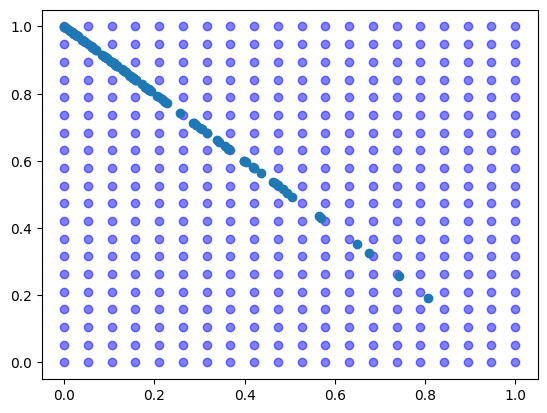

In [9]:
alpha = np.array([1.0, 4.])

R, mu, r = dirichlet_chebyshev_constraints(alpha, 0.8)
plot_ellipsoid(R, mu, r, c='blue', alpha=0.5)

dist = scipy.stats.dirichlet(alpha)
x = dist.rvs(100)
plt.scatter(x[:, 0], x[:, 1])

plt.show()

# Verify correctness of HPD

In [10]:
def dirichlet_hpd_tau_chi2(alpha, p):
    """
    Approximate HPD superlevel threshold tau for Dir(alpha) with coverage p
    using a Laplace/Wilks chi-square approximation (no sampling).
    Valid/accurate when all alpha_i > 1 and alpha_0 is not tiny.
    """
    alpha = np.asarray(alpha, float)
    if not (0.0 < p < 1.0):
        return -np.inf if p <= 0 else np.inf
    if (alpha <= 1).any():
        raise ValueError("chi^2 HPD approximation needs all alpha_i > 1 (interior mode).")

    K = alpha.size
    a0 = alpha.sum()
    mode = (alpha - 1.0) / (a0 - K)  # interior mode
    tau = float(np.dot(alpha - 1.0, np.log(mode)) - 0.5 * scipy.stats.chi2.ppf(p, df=K - 1))
    return tau

In [11]:
def plot_feasible_region(alpha, p, n_points=20):
    tau = dirichlet_hpd_tau_chi2(alpha, p)
    X = np.linspace(0.01, 0.99, n_points)
    Y = np.linspace(0.01, 0.99, n_points)
    X, Y = np.meshgrid(X, Y)
    Z = (alpha[0] - 1.0) * np.log(X) + (alpha[1] - 1.0) * np.log(Y)
    valid = Z >= tau
    X_valid = X[valid]
    Y_valid = Y[valid]
    plt.scatter(X_valid, Y_valid)


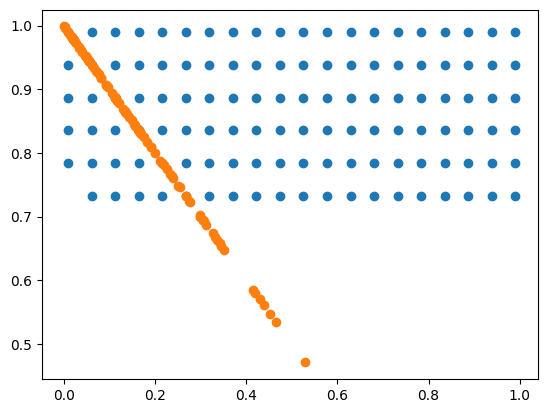

In [12]:
alpha = np.array([1.1, 6.])

plot_feasible_region(alpha, 0.9)

dist = scipy.stats.dirichlet(alpha)
x = dist.rvs(100)
plt.scatter(x[:, 0], x[:, 1])

plt.show()

# Dirichlet HPD smoothing

In [13]:
def get_powerlaw_weights(max_val=1000, alpha=1., beta=1.):
    xs = np.arange(max_val)
    ws_1 = np.power(alpha + np.abs(xs - max_val / 3), -beta)
    ws_2 = np.power(alpha + np.abs(xs - 2 * max_val / 3), -beta)
    ws = (ws_1 + ws_2) / 2
    return ws / ws.sum()

def draw_sample(size, max_val=1000, alpha=1., beta=1.):
    weights = get_powerlaw_weights(max_val, alpha, beta)
    return np.random.choice(np.arange(max_val), size=size, p=weights)

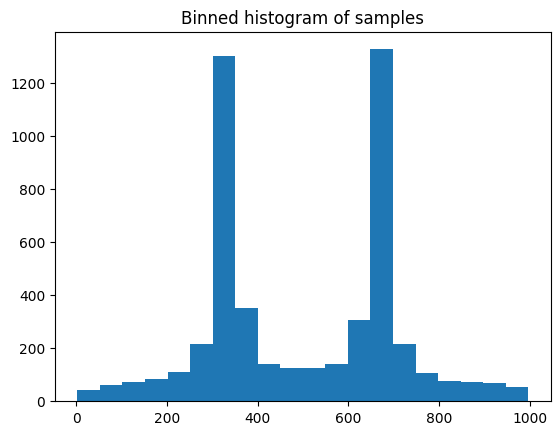

In [14]:
max_val = 1000
n_samples = 5000

samples = draw_sample(n_samples, max_val=max_val)
plt.hist(samples, bins=20)
plt.title('Binned histogram of samples')
plt.show()

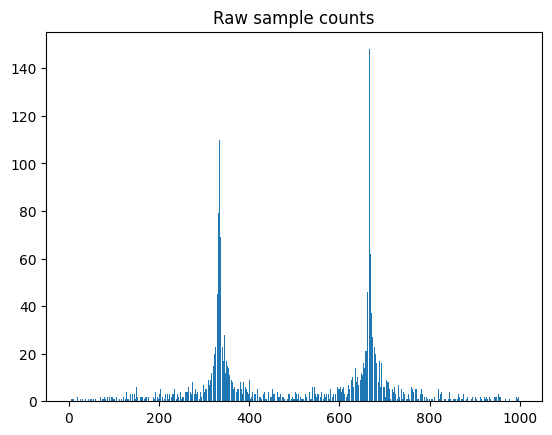

In [15]:
counts = np.bincount(samples, minlength=max_val)
plt.bar(np.arange(max_val), counts)
plt.title('Raw sample counts')
plt.show()

In [16]:
confidence = 0.05
diff_order = 1

alpha = 2 + counts
tau = dirichlet_hpd_tau_chi2(alpha, confidence)
print(tau)

x = cp.Variable(max_val)
smoothness = cp.norm(cp.diff(x, diff_order))
constraints = [cp.mean(cp.multiply(alpha - 1.0, cp.log(x))) >= tau,
               cp.sum(x) == 1,
               x >= 0]

objective = cp.Minimize(smoothness)
prob = cp.Problem(objective, constraints)
prob.solve()

-37830.76073629465


np.float64(2.670039414814648e-14)

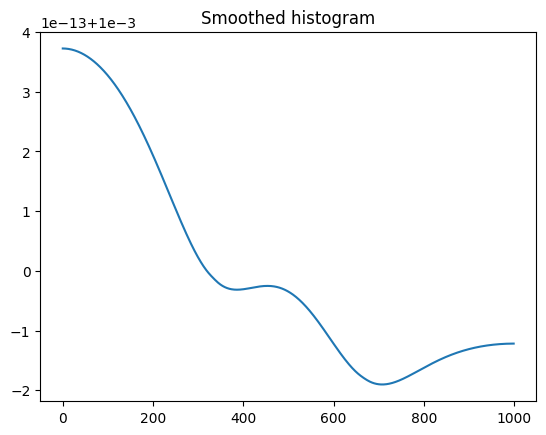

In [17]:
plt.plot(np.arange(max_val), x.value)
plt.title('Smoothed histogram')
plt.show()


# Dirichlet beta marginal constraints

In [18]:
def dirichlet_beta_marginals_constraints(alpha, p):
    """
    Beta-marginals confidence polytope for Dirichlet(alpha).

    Builds convex constraints of the form:
        L_i <= x_i <= U_i  for all i
    where L_i, U_i are Beta-marginal quantiles chosen so that, by the union
    bound, P(x in box) >= p.

    Parameters
    ----------
    alpha : array_like, shape (K,)
        Dirichlet parameters (>0).
    x : cvxpy.Variable or Expression, shape (K,) or (K,1)
        Probability vector variable (assumed already constrained to the simplex elsewhere).
    p : float in [0, 1]
        Desired joint coverage (e.g., 0.90).

    Returns
    -------
        lo, hi: array_like, shape (K,)
            Lower and upper bounds for each coordinate of x.

    Notes
    -----
    Uses Bonferroni/union bound with uniform error split:
        ε_i = (1 - p)/K,
        L_i = Beta(alpha_i, a0 - alpha_i)^{-1}(ε_i / 2),
        U_i = Beta(alpha_i, a0 - alpha_i)^{-1}(1 - ε_i / 2).
    """
    alpha = np.asarray(alpha, dtype=float)

    a0 = alpha.sum()
    a = alpha
    b = a0 - alpha
    # Uniform Bonferroni split of tail probability across coordinates
    eps_i = (1.0 - p) / alpha.size
    lo = scipy.stats.beta.ppf(eps_i / 2.0, a, b)
    hi = scipy.stats.beta.ppf(1.0 - eps_i / 2.0, a, b)

    # Guard against tiny numerical excursions outside [0,1]
    lo = np.clip(lo, 0.0, 1.0)
    hi = np.clip(hi, 0.0, 1.0)

    return lo, hi

In [19]:
confidence = 0.01
diff_order = 1

alpha = 2 + counts
lo, hi = dirichlet_beta_marginals_constraints(alpha, confidence)

x = cp.Variable(max_val)
smoothness = cp.norm(cp.diff(x, diff_order))
constraints = [x >= lo, x <= hi,
               cp.sum(x) == 1,
               x >= 0.01 / max_val]

objective = cp.Minimize(smoothness)
prob = cp.Problem(objective, constraints)
prob.solve()

np.float64(0.007912217083452059)

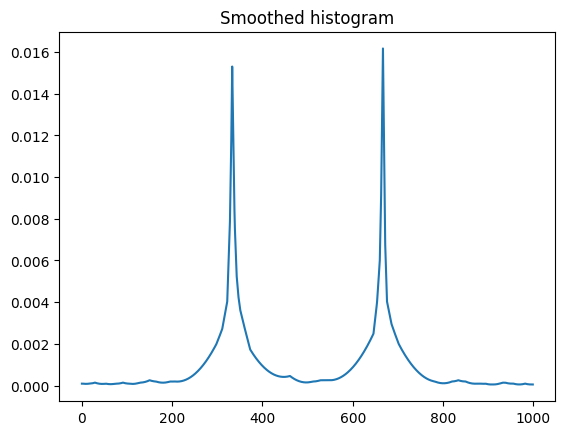

In [20]:
plt.plot(np.arange(max_val), x.value)
plt.title('Smoothed histogram')
plt.show()

# Smoothing via EMD distance

In [21]:
def emd(x, p_hat):
    cum_diff = cp.cumsum(x - p_hat)   # shape (K,)
    return cp.norm1(cum_diff[:-1])

In [22]:
def max_nonzero_distance(z):
    """
    Maximum distance (index gap) between consecutive nonzero entries in z.
    Returns 0 if fewer than two nonzeros.
    """
    idx = np.flatnonzero(z)
    if idx.size < 2:
        return 0
    return int(np.diff(idx).max())

In [23]:
eps = max_nonzero_distance(counts) / 2
diff_order = 1

x = cp.Variable(max_val, nonneg=True)
hist = counts / np.sum(counts)
constraints = [cp.sum(x) == 1,
               x >= 0.01 / max_val,
               emd(x, hist) <= eps]
objective = cp.Minimize(cp.norm1(cp.diff(x, diff_order)))
prob = cp.Problem(objective, constraints)
prob.solve()

np.float64(0.022630169594860944)

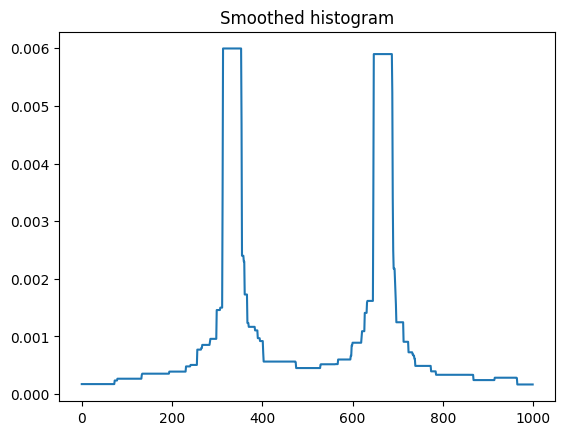

In [24]:
plt.plot(np.arange(max_val), x.value)
plt.title('Smoothed histogram')
plt.show()

# Use TV distance - the amount of mass that needs to be moved

In [25]:
def tv_unit_constraints_cumsum(x, p_hat, eps):
    """
    Enforce TV(x, p_hat) <= eps for 1-D unit-width bins via CVXPY's cumsum atom.

    Assumes p_hat is a 1-D normalized histogram (sum=1).
    Usually you'll also add simplex constraints on x: x>=0, sum(x)==1.
    """
    return cp.norm1(x - p_hat) <= 2 * eps

In [26]:
eps = 1 / np.sqrt(n_samples)
diff_order = 1

x = cp.Variable(max_val, nonneg=True)
hist = counts / np.sum(counts)
constraints = [cp.sum(x) == 1,
               tv_unit_constraints_cumsum(x, hist, eps)]
objective = cp.Minimize(cp.norm(cp.diff(x, diff_order)))
prob = cp.Problem(objective, constraints)
prob.solve()

np.float64(0.02370324100244882)

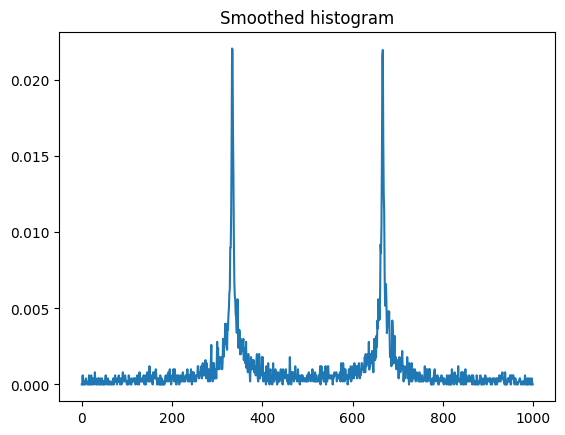

In [27]:
plt.plot(np.arange(max_val), x.value)
plt.title('Smoothed histogram')
plt.show()

# Spectral smoothing

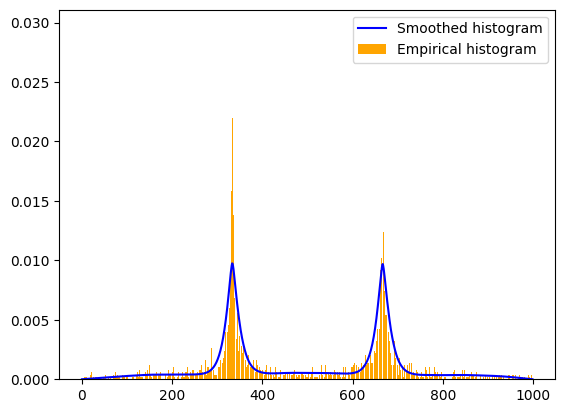

In [70]:
# obtain empirical histogram from samples in [0..max_val)
counts = np.bincount(samples, minlength=max_val)
empirical_hist = counts / np.sum(counts)

# number of Eigenvectors to use
# typically - expected max. number of modes in the histogram
num_coefs = 10

# obtain the eigenspace of L + diag(p), where p is the empirical histogram
diag = 2 * np.ones(max_val) - empirical_hist
off_diag = -np.ones(max_val - 1)
eigvals, eigvecs = scipy.linalg.eigh_tridiagonal(
    diag,
    off_diag,
    select='i',
    select_range=(0, num_coefs)
)

# project the empirical histogram onto the eigenspace
coefficients = eigvecs.T @ empirical_hist
apx_hist = eigvecs @ coefficients

# plot the smoothed histogram and the empirical histogram
plt.plot(apx_hist, label='Smoothed histogram', color='blue')
plt.bar(np.arange(max_val), empirical_hist, label='Empirical histogram', color='orange')
plt.legend()
plt.show()

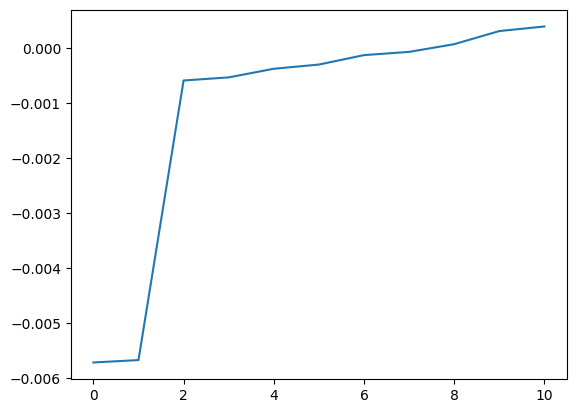

In [71]:
plt.plot(eigvals)

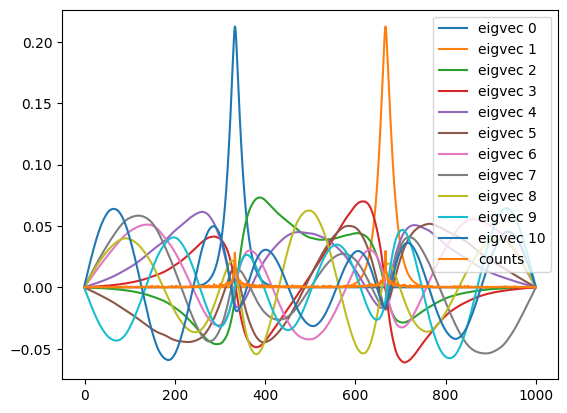

In [72]:
for i in range(1 + num_coefs):
    plt.plot(eigvecs[:, i], label=f'eigvec {i}')
plt.plot(counts / np.sum(counts), label='counts')
plt.legend()
plt.show()

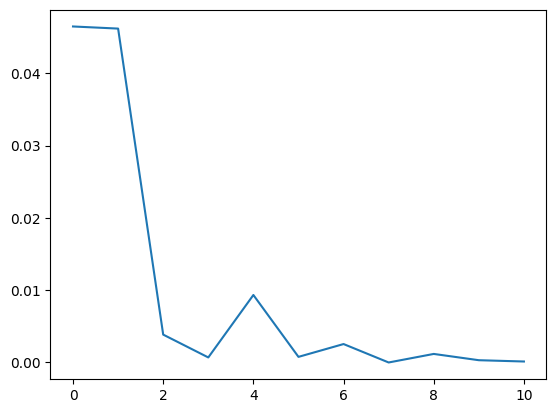

In [73]:
coefficients = eigvecs.T @ empirical_hist
plt.plot(coefficients)

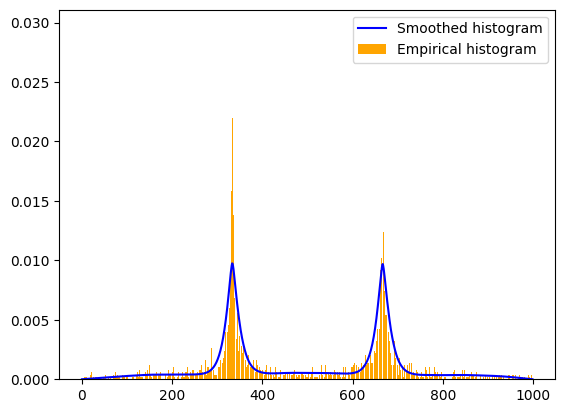

In [74]:
apx_hist = eigvecs @ coefficients
plt.plot(apx_hist, label='Smoothed histogram', color='blue')
plt.bar(np.arange(max_val),empirical_hist, label='Empirical histogram', color='orange')
plt.legend()
plt.show()


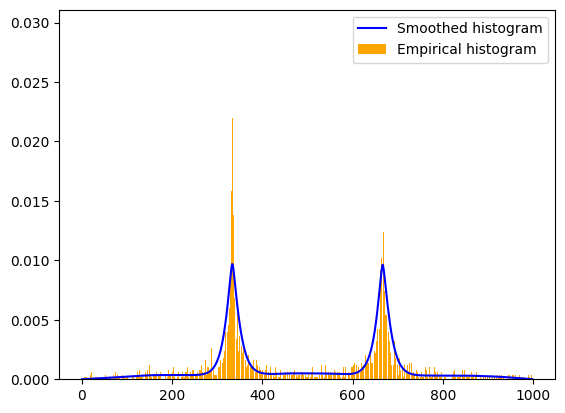

In [75]:
# NNL approximation
coef_var = cp.Variable(eigvals.shape[0])
obj = cp.Minimize(cp.norm(eigvecs @ coef_var - empirical_hist))
constraints = [
    cp.sum(eigvecs @ coef_var) == 1,
    (eigvecs @ coef_var) >= 0
]
prob = cp.Problem(obj, constraints)
prob.solve()
coefs = coef_var.value

apx_hist = eigvecs @ coefs
plt.plot(apx_hist, label='Smoothed histogram', color='blue')
plt.bar(np.arange(max_val), empirical_hist, label='Empirical histogram', color='orange')
plt.legend()
plt.show()